In [5]:
def load_and_preprocess_vix_data():
    
    """Load and preprocess VIX data from CSV with proper datetime parsing"""
    try:
        # Load VIX data with proper datetime parsing
        vix_data = pd.read_csv(
            'hist_india_vix_-18-06-2024-to-17-06-2025.csv',
            parse_dates=['Date '],
            date_parser=lambda x: pd.to_datetime(x, format='%d-%b-%Y')
              # Specify your actual date format
        )

        vix_data.columns = [
        'date', 'vix_open', 'vix_high', 'vix_low', 'vix_close',
        'vix_prev_close', 'vix_change', 'vix_pct_change']

        
        # Set date as index with proper datetime handling
        vix_data['date'] = pd.to_datetime(vix_data['date'], format='%Y-%m-%d').dt.tz_localize(None)  # Specify format
        vix_data.set_index('date', inplace=True)
        return vix_data
    except Exception as e:
        print(f"Error loading VIX data: {str(e)}")
        vix_data = None

C:\Users\dasdi\AppData\Local\Temp\ipykernel_22960\3645163300.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  vix_data = pd.read_csv(



          COMPREHENSIVE INDIAN MARKET ANALYSIS

=== TREND & MOMENTUM ===
SENSEX: 81556.38 | 12MA: 81764.37 | 26MA: 81684.04
Trend: Bearish | RSI (14-day): 51.03 → Neutral

=== VOLATILITY ===
India VIX: 14.84 (Mean: 14.84, 75th %ile: 15.65)
VIX Sentiment: Moderate (Neutral)

=== MARKET BREADTH ===
Advance-Decline Ratio: 0.85 → 🔍 Neutral
Smallcap 250 (5d Return): -2.19% | Midcap 150: -2.23%

=== SECTORAL PERFORMANCE ===
              5d Return %
Nifty IT         0.589051
Nifty Auto       0.134331
Nifty Bank      -0.803726
Nifty FMCG      -1.396994
Nifty Pharma    -2.656315

Sector Sentiment: ✅ Risk-On (Cyclicals Leading)
Strongest Sector: Nifty IT | Weakest Sector: Nifty Pharma

=== COMBINED INTERPRETATION ===
🔍 NEUTRAL: Mixed signals. Wait for confirmation.


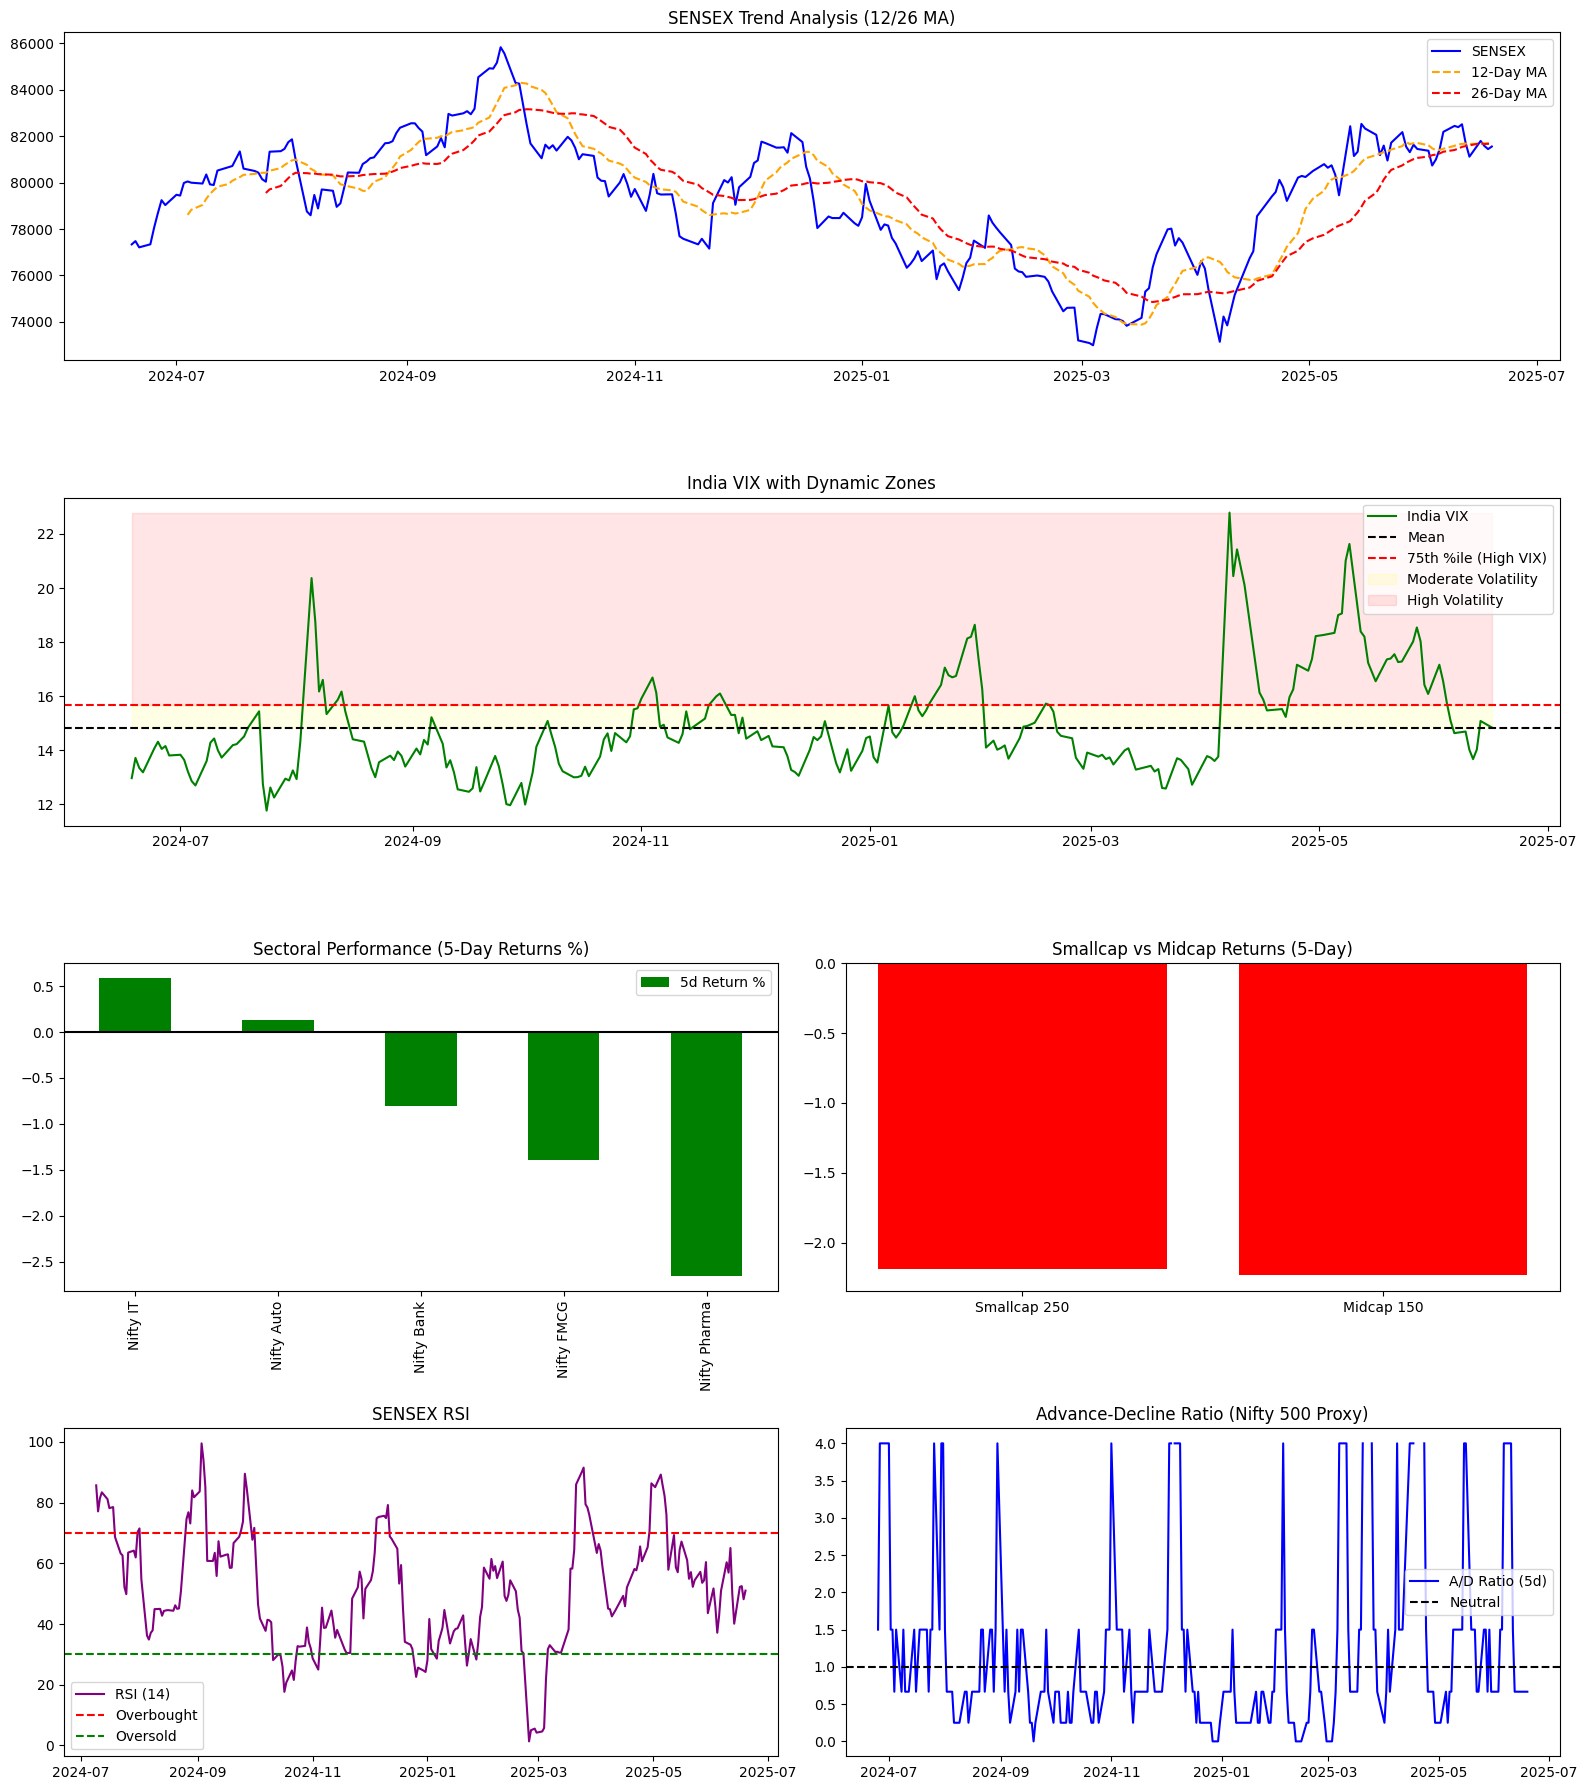

In [16]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# ===== 1. Fetch Data =====
def fetch_data(ticker, period="1y"):
    tck = yf.Ticker(ticker)
    return tck.history(period=period)

# Benchmark Indices
sensex = fetch_data("^BSESN")
india_vix = load_and_preprocess_vix_data()
nifty_smallcap = fetch_data("0P0001PR8B.BO")  # SBI NIFTY Small-cap index 250
nifty_midcap = fetch_data("0P0001NYM3.BO")    # ICICI Pru Nifty Midcap 150 Idx Reg Gr

# Sectoral Indices
sectors = {
    "Nifty Bank": "^NSEBANK",
    "Nifty IT": "^CNXIT",
    "Nifty FMCG": "^CNXFMCG",
    "Nifty Auto": "^CNXAUTO",
    "Nifty Pharma": "^CNXPHARMA",
}
sector_data = {sector: fetch_data(ticker, "3mo") for sector, ticker in sectors.items()}

# ===== 2. Calculate Indicators =====
# Moving Averages (SENSEX) - Changed to 12 and 26 days
sensex['MA_12'] = sensex['Close'].rolling(window=12).mean()
sensex['MA_26'] = sensex['Close'].rolling(window=26).mean()

# Dynamic VIX Thresholds
vix_mean = india_vix['vix_close'].mean()
vix_std = india_vix['vix_close'].std()
vix_75perc = np.percentile(india_vix['vix_close'], 75)

# RSI (14-day for SENSEX)
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

sensex['RSI'] = compute_rsi(sensex['Close'])

# Advance-Decline Ratio (Proxy: Nifty 500 A/D)
nifty_500 = fetch_data("^CRSLDX")  # Nifty 500 (proxy)
nifty_500['Advance'] = nifty_500['Close'] > nifty_500['Open']
nifty_500['Decline'] = nifty_500['Close'] < nifty_500['Open']
ad_ratio = nifty_500['Advance'].sum() / max(nifty_500['Decline'].sum(), 1)  # Avoid division by zero

# Sectoral Performance (5-day returns)
sector_returns = pd.DataFrame({
    sector: data['Close'].pct_change(5).iloc[-1] * 100  # 5d returns in %
    for sector, data in sector_data.items()
}, index=["5d Return %"]).T.sort_values("5d Return %", ascending=False)

# Smallcap/Midcap Performance
smallcap_return = nifty_smallcap['Close'].pct_change(5).iloc[-1] * 100
midcap_return = nifty_midcap['Close'].pct_change(5).iloc[-1] * 100

# ===== 3. Generate Signals =====
# Trend Signal - Updated to use 12 and 26 MA
trend = "Bullish" if (sensex['Close'].iloc[-1] > sensex['MA_12'].iloc[-1] and 
                      sensex['Close'].iloc[-1] > sensex['MA_26'].iloc[-1]) else "Bearish"

# VIX Signal
if india_vix['vix_close'].iloc[-1] < vix_mean:
    vix_sentiment = "Low (Bullish)"
elif india_vix['vix_close'].iloc[-1] > vix_75perc:
    vix_sentiment = "Very High (Bearish)"
else:
    vix_sentiment = "Moderate (Neutral)"

# Sector Signal
top_sector = sector_returns.index[0]
if "Bank" in top_sector or "Auto" in top_sector or "IT" in top_sector:
    sector_sentiment = "✅ Risk-On (Cyclicals Leading)"
elif "FMCG" in top_sector or "Pharma" in top_sector:
    sector_sentiment = "⚠️ Risk-Off (Defensives Leading)"
else:
    sector_sentiment = "🔍 Neutral (Mixed)"

# Breadth Signal
if ad_ratio > 1.5:
    breadth_sentiment = "✅ Broad Participation (Bullish)"
elif ad_ratio < 0.7:
    breadth_sentiment = "❌ Weak Participation (Bearish)"
else:
    breadth_sentiment = "🔍 Neutral"

# RSI Signal
rsi = sensex['RSI'].iloc[-1]
if rsi > 70:
    rsi_sentiment = "⚠️ Overbought (Caution)"
elif rsi < 30:
    rsi_sentiment = "📈 Oversold (Opportunity)"
else:
    rsi_sentiment = "Neutral"

# ===== 4. Print Analysis =====
print("\n" + "="*60)
print("          COMPREHENSIVE INDIAN MARKET ANALYSIS")
print("="*60)

print("\n=== TREND & MOMENTUM ===")
print(f"SENSEX: {sensex['Close'].iloc[-1]:.2f} | 12MA: {sensex['MA_12'].iloc[-1]:.2f} | 26MA: {sensex['MA_26'].iloc[-1]:.2f}")
print(f"Trend: {trend} | RSI (14-day): {rsi:.2f} → {rsi_sentiment}")

print("\n=== VOLATILITY ===")
print(f"India VIX: {india_vix['vix_close'].iloc[-1]:.2f} (Mean: {vix_mean:.2f}, 75th %ile: {vix_75perc:.2f})")
print(f"VIX Sentiment: {vix_sentiment}")

print("\n=== MARKET BREADTH ===")
print(f"Advance-Decline Ratio: {ad_ratio:.2f} → {breadth_sentiment}")
print(f"Smallcap 250 (5d Return): {smallcap_return:.2f}% | Midcap 150: {midcap_return:.2f}%")

print("\n=== SECTORAL PERFORMANCE ===")
print(sector_returns)
print(f"\nSector Sentiment: {sector_sentiment}")
print(f"Strongest Sector: {top_sector} | Weakest Sector: {sector_returns.index[-1]}")

print("\n=== COMBINED INTERPRETATION ===")
if trend == "Bullish" and vix_sentiment == "Low (Bullish)" and "Risk-On" in sector_sentiment:
    print("✅ STRONG BULLISH: Broad rally + Low fear + Cyclicals leading")
elif trend == "Bullish" and vix_sentiment == "Very High (Bearish)":
    print("⚠️ CAUTION: Bullish but fragile (High VIX + Possible reversal)")
elif trend == "Bearish" and vix_sentiment == "Very High (Bearish)":
    print("❌ BEARISH: Downtrend + Panic + Defensives safe-haven")
else:
    print("🔍 NEUTRAL: Mixed signals. Wait for confirmation.")

# ===== 5. Plotting =====
plt.figure(figsize=(16, 18))
gs = GridSpec(4, 2, figure=plt.gcf())

# Plot 1: SENSEX and MAs (updated to show 12 and 26 MA)
ax1 = plt.subplot(gs[0, :])
ax1.plot(sensex['Close'], label='SENSEX', color='blue')
ax1.plot(sensex['MA_12'], label='12-Day MA', linestyle='--', color='orange')
ax1.plot(sensex['MA_26'], label='26-Day MA', linestyle='--', color='red')
ax1.set_title('SENSEX Trend Analysis (12/26 MA)')
ax1.legend()

# Plot 2: India VIX Zones
ax2 = plt.subplot(gs[1, :])
ax2.plot(india_vix['vix_close'], label='India VIX', color='green')
ax2.axhline(y=vix_mean, linestyle='--', color='black', label='Mean')
ax2.axhline(y=vix_75perc, linestyle='--', color='red', label='75th %ile (High VIX)')
ax2.fill_between(india_vix.index, vix_mean, vix_75perc, color='yellow', alpha=0.1, label='Moderate Volatility')
ax2.fill_between(india_vix.index, vix_75perc, india_vix['vix_close'].max(), color='red', alpha=0.1, label='High Volatility')
ax2.set_title('India VIX with Dynamic Zones')
ax2.legend()

# Plot 3: Sectoral Heatmap
ax3 = plt.subplot(gs[2, 0])
sector_returns.plot(kind='bar', ax=ax3, color=['green' if x > 0 else 'red' for x in sector_returns['5d Return %']])
ax3.axhline(y=0, color='black', linestyle='-')
ax3.set_title('Sectoral Performance (5-Day Returns %)')

# Plot 4: Smallcap vs Midcap
ax4 = plt.subplot(gs[2, 1])
ax4.bar(['Smallcap 250', 'Midcap 150'], [smallcap_return, midcap_return], 
        color=['green' if x > 0 else 'red' for x in [smallcap_return, midcap_return]])
ax4.set_title('Smallcap vs Midcap Returns (5-Day)')

# Plot 5: RSI
ax5 = plt.subplot(gs[3, 0])
ax5.plot(sensex['RSI'], label='RSI (14)', color='purple')
ax5.axhline(y=70, linestyle='--', color='red', label='Overbought')
ax5.axhline(y=30, linestyle='--', color='green', label='Oversold')
ax5.set_title('SENSEX RSI')
ax5.legend()

# Plot 6: Advance-Decline Ratio
ax6 = plt.subplot(gs[3, 1])
ax6.plot(nifty_500.index, nifty_500['Advance'].rolling(5).sum() / nifty_500['Decline'].rolling(5).sum(), 
         label='A/D Ratio (5d)', color='blue')
ax6.axhline(y=1.0, linestyle='--', color='black', label='Neutral')
ax6.set_title('Advance-Decline Ratio (Nifty 500 Proxy)')
ax6.legend()

plt.tight_layout()
plt.show()